In [ ]:
## reference https://huggingface.co/learn/nlp-course/en/chapter7/6?fw=pt#training-a-causal-language-model-from-scratch

In [2]:
import deepspeed

/opt/conda/compiler_compat/ld: cannot find -laio
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


In [2]:
#installing some libraries
!pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig,AutoModelForCausalLM
from transformers import DataCollatorForLanguageModeling



import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch import cuda
import datetime 
import warnings,itertools
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import autocast, GradScaler

# Ignore all warnings
warnings.filterwarnings('ignore')
#pip install transformers bitsandbytes>=0.39.0 -q
import zipfile
import deepspeed

In [5]:
#global params for training

batch_size = 32
epoch = 15
min_text_len = 0
# train_loss_list = []
# val_loss_list =[]
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
#print(device)
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#os.environ["MKL_DEBUG_CPU_TYPE"] = "5"
context_length = None
global_tr_loss = torch.inf
global_val_loss = torch.inf
#print(global_tr_loss)
model_path = os.path.join("model")
print(model_path)

cuda:0
model


In [38]:
def get_deepspeed_config(loader,batch_size = batch_size , num_epoch = epoch):
    
    ds_config = {
    "train_batch_size": batch_size ,  # batch_size * gradient_accumulation_steps * num_GPUs
    "gradient_accumulation_steps": 4,
    "fp16": {"enabled": True},
    "zero_optimization": {"stage": 2},
    "optimizer": {"type": "Adam","params": {"lr": 5e-5} },
    "scheduler": {"type": "WarmupCosineLR",
                  "params": {"warmup_num_steps": len(loader)*num_epoch*.1, "total_num_steps": len(loader)*num_epoch }
                 },
    
}
    return ds_config

    
    

In [7]:
directory = os.path.join('.','data','unzip_text_100M')  # Replace with your directory path
directory

'./data/unzip_text_100M'

In [8]:
def read_text(directory):
    directory = os.path.join('.','data','unzip_text_100M',str(directory))  # Replace with your directory path
    print(f"directory :{directory}")
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print(f"files:{files}")
    text_content = []
    # Read each file
    total_lines = 0
    for filenum,filename in enumerate(files):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            #first_line = file.read()
            #print(f"filename :{filename}->first few lines {first_line}")
            #continue
            lines_list = [line.strip() for line in open(file_path, 'r')]
            print(f"the file:{filename} added {len(lines_list)} rows to the list")
            total_lines+=len(lines_list)
            text_content.append(lines_list)
    
    flattened_list = list(itertools.chain(*text_content))
    assert (len(flattened_list) == total_lines , f"Expected {len(flattened_list)} to be equal to {total_lines}" )
    
    return flattened_list

    

In [9]:
train_list = read_text("train_100M")
#print(train_dict)
#val_list = read_text("dev")

directory :./data/unzip_text_100M/train_100M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train added 161740 rows to the list
the file:simple_wiki.train added 646969 rows to the list
the file:open_subtitles.train added 3495000 rows to the list
the file:gutenberg.train added 676014 rows to the list
the file:childes.train added 5790000 rows to the list
the file:bnc_spoken.train added 818961 rows to the list


In [10]:
train_list[:10]

['A:\tOkay.',
 'A:\tSo, What kind of experience do you, do you have, then with child care?',
 'B:\tI guess, I think, uh, I wonder if that worked.',
 'A:\tDoes it say something?',
 'B:\tI think it usually does.',
 'B:\tYou might try, uh,',
 "B:\tI don't know,",
 'B:\thold it down a little longer,',
 'B:\tand see if it, uh,',
 'A:\tOkay']

In [11]:
df_train = pd.DataFrame(read_text("train_100M"), columns=['text'])
df_val = pd.DataFrame(read_text("dev"), columns=['text'])


directory :./data/unzip_text_100M/train_100M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train added 161740 rows to the list
the file:simple_wiki.train added 646969 rows to the list
the file:open_subtitles.train added 3495000 rows to the list
the file:gutenberg.train added 676014 rows to the list
the file:childes.train added 5790000 rows to the list
the file:bnc_spoken.train added 818961 rows to the list
directory :./data/unzip_text_100M/dev
files:['switchboard.dev', 'simple_wiki.dev', 'open_subtitles.dev', 'gutenberg.dev', 'childes.dev', 'bnc_spoken.dev']
the file:switchboard.dev added 18000 rows to the list
the file:simple_wiki.dev added 60000 rows to the list
the file:open_subtitles.dev added 375000 rows to the list
the file:gutenberg.dev added 65000 rows to the list
the file:childes.dev added 520153 rows to the list
the file:bnc_spoken.dev added 130000 rows to the list


In [12]:
df_train.head()

,text
0,A:\tOkay.
1,"A:\tSo, What kind of experience do you, do you..."
2,"B:\tI guess, I think, uh, I wonder if that wor..."
3,A:\tDoes it say something?
4,B:\tI think it usually does.


In [13]:
print(len(df_train))
print(len(df_val))

11588684
1168153


In [12]:
df_train.head()

,text
0,A:\tOkay.
1,"A:\tSo, What kind of experience do you, do you..."
2,"B:\tI guess, I think, uh, I wonder if that wor..."
3,A:\tDoes it say something?
4,B:\tI think it usually does.


In [14]:
#let's create a new column called 'length' on our dataframe to analyze the text

df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_val['length'] = df_val['text'].apply(lambda x: len(x))
#df_test['length'] = df_test['text'].apply(lambda x: len(x))


In [15]:
df_train.head()

,text,length
0,A:\tOkay.,8
1,"A:\tSo, What kind of experience do you, do you...",73
2,"B:\tI guess, I think, uh, I wonder if that wor...",49
3,A:\tDoes it say something?,25
4,B:\tI think it usually does.,27


## Analyzing the length of the text

In [16]:
print(f"the range of length in the train set is {max(df_train.length)} down to {min(df_train.length)}")

the range of length in the train set is 20199 down to 0


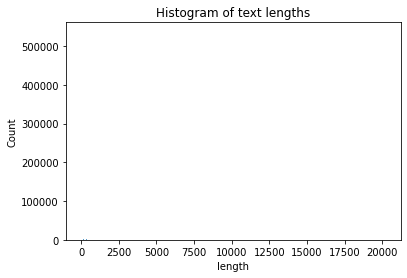

In [17]:
## Lets check the the distributions

sns.histplot(df_train['length'], bins='auto')
plt.title('Histogram of text lengths')
plt.show()


#### we see that majority of the text is between 0 and 2000. Since the maximum length of text the GPT model handles is 1024, let's see that distribution.

In [18]:
import numpy as np


array = np.arange(0, 2000, step=100)
print(array)


[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900]


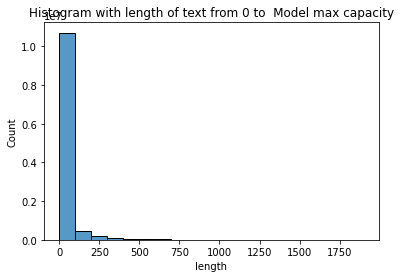

In [19]:
sns.histplot(df_train['length'], bins= array)
plt.title('Histogram with length of text from 0 to  Model max capacity')
plt.show()

In [20]:
# Let us check the number of rows whose length > 1024(the defualt length that the tokenizer can process)
exceed_tok_len = sum(df_train['length']> 1024)/len(df_train)*100
print(f"fewer than {exceed_tok_len}% of rows have text more than the length of model")

fewer than 0.11859845345683771% of rows have text more than the length of model


In [21]:
#Lets check for the number of rows where length is 0
sum(df_train['length'] == min_text_len)


131035

#### We notice that some of the rows in our dataframe have no text.
Removing such rows and resetting the indices 

In [22]:
df_train = df_train[df_train['length'].astype(bool)]

In [23]:
df_val = df_val[df_val['length'].astype(bool)]

In [24]:
sum(df_train['length'] == min_text_len)

0

In [25]:
sum(df_val['length'] == 0)

0

In [26]:
df_train.head()

,text,length
0,A:\tOkay.,8
1,"A:\tSo, What kind of experience do you, do you...",73
2,"B:\tI guess, I think, uh, I wonder if that wor...",49
3,A:\tDoes it say something?,25
4,B:\tI think it usually does.,27


In [27]:
# resetting the index
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)


In [28]:
#calc the average len of the text:
mean_len = int(df_train.length.mean())
print(mean_len)
import math
power = math.ceil(math.log2(mean_len))
print(power)
context_length = 2**power
context_length
print(f"The context length is {context_length} ")

45
6
The context length is 64 


In [29]:
# Test the tokenizer:
#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2", padding = True ,return_tensors = "pt" , truncate = True, max_length  = context_length ,return_overflowing_tokens=True)
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2",return_tensors = "pt" , truncate = True, max_length  = context_length ,return_overflowing_tokens=True , padding = False)

#tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("distilgpt2")
#model = AutoModelForCausalLM.from_pretrained('./model/model2024-05-2923:30:09_.pth', from_flax=False)




tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [29]:
tokenizer.save_pretrained("./model")

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.json',
 './model/merges.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

### Data loaders and Dataset for batched training

In [30]:
class dataset_pyt(Dataset):
    def __init__(self, df, tokenizer, max_length = context_length ):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
                                
    def __getitem__(self, idx):
        #print(f"inside loader...idx ->{idx}")
        text = self.df.iloc[idx]['text']
        #print(f"length of text ->{len(text)}")
        #print(f"text ->{text}")
        #encodings = tokenizer(text, truncation=True, max_length= self.max_length, return_overflowing_tokens=True, padding = 'max_length',return_tensors='pt')
        encodings = tokenizer(text, truncation=True, max_length= self.max_length, return_overflowing_tokens=True, padding = False)
        # check the length of the encoded list
        
        #x_dict['input_id'] = input_ids_list
        #x_dict['attention_mask'] = input_ids_list
                
        #print(f"x_dict = {x_dict}")             
#       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
        #labels = input_id_list
        #input_ids = torch.tensor(input_id_list)
        #attention_mask = torch.tensor(attention_mask_list)
        #labels = torch.tensor(labels)
        #print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")
        #print(f"encoding = {encodings}")
               
        return encodings
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [31]:
def custom_collate_fn(batch, ):
    x_dict = {}
    #print("CUSTOM COllate")
    #print(f"bacth = {batch}")
    input_ids_list = []
    att_mask_list = [] 
    for elem,item in enumerate(batch):
        #print(f"element {elem}")
        #print(f"item = {item}")
        #check whether there are any nested lists :
        if len(item['input_ids']) > 1:
            #print(f"flattening the list")
            input_id_tensor = torch.tensor(list(itertools.chain(*item['input_ids'])))
            #print(f"shape of the flattended tensor = {input_id_tensor.shape}")
            input_ids_list.append(input_id_tensor[:1024])
            att_mask_tensor = torch.tensor(list(itertools.chain(*item['attention_mask'])))
            att_mask_list.append(att_mask_tensor[:1024])
        else:
            input_id_tensor = torch.tensor(item['input_ids']).squeeze(0)
            input_ids_list.append(input_id_tensor)
            att_mask_tensor = torch.tensor(item['attention_mask']).squeeze(0)
            #print(f"shape of att_mask_tensor tensor = {att_mask_tensor.shape}")
            att_mask_list.append(att_mask_tensor)
    #attention_mask = [item['attention_mask'].squeeze(0) for item in batch]

    # Pad sequences to the same length
    #print(f"len of input_id_list = {len(input_ids_list)}")
    #print(f"len of attmask_list = {len(att_mask_list)}")
    #input_id_tensor = torch.tensor(input_ids_list).squeeze()
    #att_mask_tensor = torch.tensor(att_mask_list).squeeze()
    #print("*********************")
    #print(f"input_ids_list = {input_ids_list}")
    
        
    
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.eos_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(att_mask_list, batch_first=True, padding_value=0)
    #print(f"shape of input_id tensor post padding -{input_ids.shape}")
    #print(f"shape of attention_masks tensor post padding -{attention_mask.shape}")
    x_dict['input_ids'] = input_ids
    x_dict['attention_mask'] = attention_mask
    
    return x_dict

1968

In [33]:
all_text = list(df_train['text'])
len(all_text)


11457649

In [34]:
#train_dataset = dataset_pyt(filtered_df,tokenizer = tokenizer)
train_dataset = dataset_pyt(df_train,tokenizer = tokenizer)
val_dataset = dataset_pyt(df_val,tokenizer = tokenizer)
#test_dataset = dataset_pyt(df_test,tokenizer = tokenizer)

train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True , num_workers = 4, pin_memory = True, collate_fn = custom_collate_fn)
val_loader = DataLoader(val_dataset,batch_size = batch_size*3, shuffle = True , collate_fn = custom_collate_fn, num_workers = 4, pin_memory = True)
#test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False, collate_fn = custom_collate_fn)

    

### Training the model

In [35]:
print(f"The length of train loader is {len(train_loader)}")

The length of train loader is 358052


In [36]:
#https://stackoverflow.com/questions/73948214/how-to-convert-a-pytorch-nn-module-into-a-huggingface-pretrainedmodel-object/74109727#74109727
# this code is needed to save the HF model as pre-trained and use this model as inference
# class MyConfig(PretrainedConfig):
#     model_type = 'mymodel'
#     def __init__(self, important_param=42, **kwargs):
#         super().__init__(**kwargs)
#         self.important_param = important_param

# class MyModel(PreTrainedModel):
#     config_class = MyConfig
#     def __init__(self, config):
#         super().__init__(config)
#         self.config = config
#         self.model = clf_model_drp()
#     def forward(self, ids ,token_type,att_mask):
#         return self.model(ids ,token_type,att_mask) 

In [37]:
# for ind , batch in enumerate(train_loader):
#     print(f"batch ind ={ind}")
#     print(batch['input_ids'].shape)


In [38]:
@torch.no_grad
def eval_model(val_loader, model, epoch , device = device,):
    global global_val_loss
    #m = nn.Softmax()
    model.eval()
    model.to(device)
    e = epoch+1
    val_loss_list = []
    #criterion = torch.nn.BCEWithLogitsLoss()
    print(f"inside validation data for epoch {e}")
    #y_hat_val_list = []
    #y_val_list = []
    
    for ind,x_dict  in enumerate(val_loader):
        ids = x_dict['input_ids'].to(device=device, non_blocking=True)
        att_mask = x_dict['attention_mask'].to(device=device, non_blocking=True)
        labels = ids
        with autocast():
            model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
            act_loss = model_output.loss
        
        val_loss_list.append(act_loss)
        del ids,att_mask,labels
                    
    mean_val_loss = torch.mean(torch.tensor(val_loss_list))
    if mean_val_loss < global_val_loss:
        print(f"Val loss has decreased -->reducing the global validation loss from {global_val_loss:.2f} to {mean_val_loss:.2f}")
        global_val_loss = mean_val_loss
        print(f" validation loss for epoch = {e} is {torch.mean(torch.tensor(val_loss_list)):.4f}")
        #print metrics and save the model
        #y_hat_val = torch.cat(y_hat_val_list)
        #y_val = torch.cat(y_val_list)
        #acc_val = accuracy_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy())
        #f1_val = f1_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), average='micro')
        print(f" epoch= {e} : mean val loss is {torch.mean(torch.tensor(mean_val_loss)):.4f} ")
        #save the model
        
        # Get the current date and time
        current_datetime = datetime.datetime.now()
        # Extract date and time components
        current_date = str(current_datetime.date())
        current_time = str(current_datetime.time()).split('.')[0]
        file_name = 'model'+ current_date+current_time+'_'+'.pth'
        path = os.path.join("model",file_name)
        print(f"saving the model {file_name}")
        #torch.save(model.state_dict(), path)
        model.save_pretrained(path)
        
        #plot_confusion_matrix(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), labels)
    else:
        print(f"No improvement in validation loss-->epoch= {e} and global val loss is {global_val_loss:.2f}")
        
    
    
    
      

In [39]:
def train_model(train_loader,val_loader,model,num_epoch = 30,device = device):
    global global_tr_loss
    scaler = GradScaler()
    model.train()
    device = device
    print(f"inside train model. Device = {device}")
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= 5e-5)
    model.to(device)
    #m = nn.Softmax()
    import time
    scheduler = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =len(train_loader)*num_epoch*.1 ,num_training_steps= len(train_loader)*num_epoch,last_epoch = -1 )
    accumulation_steps = 4 
    for i in range (num_epoch):
        epoch_train_loss = []
        epoch_start_time = time.time()
        
        for ind,x_dict in enumerate(train_loader):
            
            #print(f"x_dict = {x_dict}")
            id_list = x_dict['input_ids']
            #print(f"id_list{id_list}")
            if ind%10000 == 0:
                batch_time = time.time()
                duration = batch_time - epoch_start_time
                print(f"executing epoch:{i+1}, it took {duration/60} mins from beginning of epoch till batch#{ind}")
            
            ids = x_dict['input_ids'].to(device=device, non_blocking=True)
            att_mask = x_dict['attention_mask'].to(device=device, non_blocking=True)
            labels = ids
            
            with autocast():
                model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
                act_loss = model_output.loss
                      
            epoch_train_loss.append(act_loss)
            
            if i % accumulation_steps == 0:
                optimizer.zero_grad(set_to_none=True)
            
            scaler.scale(act_loss).backward()
            scheduler.step()
            
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
            
            #print(f"current LR->{scheduler.get_last_lr()}")
            
            del ids,att_mask,labels
            
        #batch processing complete    
        mean_loss = torch.mean(torch.tensor(epoch_train_loss))
        
        if mean_loss < global_tr_loss:
            print(f"training loss has decreased---> reducing the global loss from {global_tr_loss:.2f} to {mean_loss:.2f}")
            global_tr_loss = mean_loss
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.2f}")
            #printing training metrices
            #y_hat = torch.cat(y_hat_list)
            #y = torch.cat(label_list)
            #acc = accuracy_score(y.cpu().numpy(), y_hat.cpu().numpy())
            #f1 = f1_score(y.cpu().numpy(), y_hat.cpu().numpy(), average='micro')
            print(f" epoch= {i+1} : mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f} ")
            #checking validation metrices
            eval_model(val_loader, model, epoch = i , device = device)
            
        else:
            print(f"No improvement in training loss..the global training loss is -->{global_tr_loss:.2f} ")
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.2f}")
        
        
    
    return model
        
            
            
    
    

In [41]:
#get DS config "

ds_config = get_deepspeed_config(train_loader)
model_engine, optimizer, _, _ = deepspeed.initialize(model=model, config=ds_config)


[2024-06-09 20:27:47,889] [INFO] [logging.py:96:log_dist] [Rank -1] DeepSpeed info: version=0.14.2, git-hash=unknown, git-branch=unknown
[2024-06-09 20:27:47,890] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-06-09 20:27:47,891] [INFO] [comm.py:652:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2024-06-09 20:27:48,262] [INFO] [comm.py:702:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=172.18.0.3, master_port=29500
[2024-06-09 20:27:48,262] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


[W socket.cpp:464] [c10d] The server socket has failed to bind to [::]:29500 (errno: 98 - Address already in use).
[W socket.cpp:464] [c10d] The server socket has failed to bind to ?UNKNOWN? (errno: 98 - Address already in use).
[E socket.cpp:500] [c10d] The server socket has failed to listen on any local network address.


DistNetworkError: The server socket has failed to listen on any local network address. The server socket has failed to bind to [::]:29500 (errno: 98 - Address already in use). The server socket has failed to bind to ?UNKNOWN? (errno: 98 - Address already in use).

In [ ]:
# config = MyConfig(42)
# model = MyModel(config)

#train_loader,optimizer,val_loader ,num_epoch = 100, model = clf_model()
tr_model = train_model(train_loader, val_loader, model =  model)

inside train model. Device = cuda:0
executing epoch:1, it took 0.01314107577006022 mins from beginning of epoch till batch#0
executing epoch:1, it took 5.694445371627808 mins from beginning of epoch till batch#10000
executing epoch:1, it took 11.273993798096974 mins from beginning of epoch till batch#20000
executing epoch:1, it took 16.77186909914017 mins from beginning of epoch till batch#30000
executing epoch:1, it took 22.434137884775797 mins from beginning of epoch till batch#40000
executing epoch:1, it took 27.98102770249049 mins from beginning of epoch till batch#50000
executing epoch:1, it took 33.55566846529643 mins from beginning of epoch till batch#60000
executing epoch:1, it took 39.175751356283826 mins from beginning of epoch till batch#70000
executing epoch:1, it took 44.81544378598531 mins from beginning of epoch till batch#80000
executing epoch:1, it took 50.498451066017154 mins from beginning of epoch till batch#90000
executing epoch:1, it took 56.03616183201472 mins fr

### Evaluating the models on test data

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

In [ ]:
t = df_train.iloc[400327]['text']
print (t)
print(len(t))
encoded = tokenizer(t, truncation=True, max_length=context_length, return_overflowing_tokens=True, padding = 'max_length',return_length= True)
print(encoded)
input_ids = torch.tensor(encoded['input_ids'])
print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")

attention_mask = torch.tensor(encoded['attention_mask'])
#       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
labels = input_ids.clone()
print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")


In [ ]:
def final_pred(loader, model, device = device,):
    m = nn.Softmax()
    model.eval()
    model.to(device)
    test_loss_list = []
    criterion = torch.nn.BCEWithLogitsLoss()
    y_hat_test_list = []
    y_test_list = []
    for ind,(x_dict, label_vec) in enumerate(loader):
        model.to(device)
        id_list = x_dict['id']
        ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
        tok_type_list = x_dict['token_type']
        token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
        att_list = x_dict['attention_mask']
        att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
        lab = label_vec.to(torch.device('cuda:0'))
        logits = model(ids ,token_type,att_mask)
        
        probs = m(logits)
        y_hat_test_list.append(torch.argmax(probs , dim = 1))
        y_test_list.append(torch.argmax(lab , dim = 1))
        
        act_loss = criterion(logits, lab)
        test_loss_list.append(act_loss.item())
            
    mean_test_loss = torch.mean(torch.tensor(test_loss_list))
    print(f" Test loss is {torch.mean(torch.tensor(test_loss_list)):.4f}")
    #print metrics and save the model
    y_hat_test = torch.cat(y_hat_test_list)
    y_test = torch.cat(y_test_list)
    acc_test = accuracy_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy())
    f1_test = f1_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), average='micro')
    print(f"mean loss is {torch.mean(torch.tensor(mean_test_loss)):.4f} -> the accuracy is {acc_test:.2f} ->the f1 is {f1_test:.2f} ")
    #save the model
    plot_confusion_matrix(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), labels)

   
        


In [ ]:
saved_model = MyModel.from_pretrained('./model/model2024-05-1712:14:28_mrpc.pth')


In [ ]:
final_pred(test_loader , saved_model )

In [ ]:
model_new = AutoModelForCausalLM.from_pretrained('./model/model2024-05-2923:30:09_.pth', from_flax=False)

In [ ]:
model_new.save_pretrained('./model', safe_serialization=False)